In [20]:
# Allmäna imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import re

# Scikit-learn 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold # Added RandomizedSearchCV and StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# För evaluering
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
from scipy.stats import uniform, randint # Needed for RandomizedSearchCV distributions

df = pd.read_parquet('train_delay_final.parquet')

In [ ]:
# Lägger till ett par kolumner
datetime_cols = ['TripStartDate']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])
df['DayOfWeek'] = df['TripStartDate'].dt.dayofweek

df['PlanedDuration'] = (df['ArrivalAdvertised'] - df['DepartureAdvertised']).dt.total_seconds() / 60.0

df['is_delayed_6'] = (df['DelayMinutes'] >= 6).astype(int)



In [ ]:
def define_feature_groups(df):
    """Defines which columns belong to which processing group."""
    
    # Numerical features that are right-skewed and need transformation
    numerical_features = ['DistanceKm', 'PlanedDuration']
    
    # Nominal categorical features (including those with NaNs)
    nominal_categorical_features = [
        'departure_station', 'arrival_station', 'end_station_county',
        'TrainOwner', 'trip_typeoftraffic',
        'DayOfWeek', 'start_hour' # Treat DayOfWeek and start_hour as nominal for OHE
    ]

    # Binary/Ordinal features that require minimal processing (or none)
    binary_features = ['is_weekday'] 
    
    return numerical_features, nominal_categorical_features, binary_features

In [5]:

def build_preprocessor(numerical_features, nominal_categorical_features, binary_features):
    """
    Creates a ColumnTransformer to apply different preprocessing steps
    to different columns.
    """
    # Pipeline for Numerical Features (DistanceKm, PlanedDuration)
    # 1. PowerTransformer handles the right-skewed distribution.
    # 2. StandardScaler ensures features have zero mean and unit variance.
    numerical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', PowerTransformer(method='yeo-johnson', standardize=True))
    ])

    # Pipeline for Nominal Categorical Features
    # 1. Imputer fills missing values (e.g., in TrainOwner/Operator/trip_typeoftraffic)
    # 2. OneHotEncoder converts categories into binary features.
    categorical_pipeline = Pipeline(steps=[
        # Use 'most_frequent' for nominal data, fill_value='missing' works well for OHE
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        # handle_unknown='ignore' ensures robustness against new categories in test set
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Combine all pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, numerical_features),
            ('cat', categorical_pipeline, nominal_categorical_features),
            ('bin', 'passthrough', binary_features) # No transformation needed for is_weekday
        ],
        remainder='drop' # Drop any other columns not specified
    )
    return preprocessor


In [6]:

def get_transformed_dataframe(df, preprocessor, nominal_categorical_features, numerical_features, binary_features):
    """
    Applies the preprocessor to the input DataFrame and returns a new DataFrame
    with proper column names, ready for visualization and inspection.
    """
    # 1. Fit and transform the data
    X_transformed = preprocessor.fit_transform(df.drop(columns=['is_delayed']))

    # 2. Extract feature names from the OneHotEncoder
    # Get the 'onehot' step from the 'cat' transformer
    ohe_step = preprocessor.named_transformers_['cat'].named_steps['onehot']
    
    # Get the names of the encoded columns
    feature_names_out = list(numerical_features)
    feature_names_out.extend(ohe_step.get_feature_names_out(nominal_categorical_features))
    feature_names_out.extend(binary_features)

    # 3. Create the final DataFrame
    transformed_df = pd.DataFrame(X_transformed, columns=feature_names_out)
    
    # 4. Add the target variable back (since we dropped it earlier)
    transformed_df['is_delayed'] = df['is_delayed'].values 
    
    print(f"\n--- Transformed DataFrame Dimensions for Visualization ---")
    print(f"Shape: {transformed_df.shape}")
    print(f"Columns: {len(transformed_df.columns)}")
    
    return transformed_df

In [ ]:
def clean_and_rename_future_data(df_future):
    """
    Transforms the future data schema to match the trained model's input features.
    """
    print("\nCleaning and renaming future data to match trained pipeline schema...")
    
    # 1. Define the necessary columns (matching the original training features)
    # The model expects these 11 columns (plus the target 'is_delayed' which is not present)
    required_feature_map = {
        'distance_km': 'DistanceKm',
        'duration_minutes': 'PlanedDuration',
        'start_weekday_': 'DayOfWeek',
        'start_hour': 'start_hour',
        'is_weekday': 'is_weekday',
        'start_station': 'departure_station',
        'end_station': 'arrival_station',
        'ToLocations': 'end_station_county', # Assuming 'ToLocations' holds the county info
        'TrainOwner': 'TrainOwner',
        'start_typeoftraffic': 'trip_typeoftraffic'
    }

    # 2. Select and rename columns
    df_cleaned = df_future[list(required_feature_map.keys())].rename(columns=required_feature_map)

    # 3. Ensure data types match the categories used during training
    # The preprocessor expects these to be categorical, even if they contain integers
    categorical_cols = ['DayOfWeek', 'start_hour', 'departure_station', 'arrival_station', 
                        'end_station_county', 'TrainOwner', 'trip_typeoftraffic']
    
    for col in categorical_cols:
        # We must cast back to category type for the fitted OneHotEncoder to work correctly
        df_cleaned[col] = df_cleaned[col].astype('category')
        
    print("Future data schema matched successfully.")
    return df_cleaned

In [ ]:
# --- Main Execution ---
df = df.copy()

X = df.drop('is_delayed', axis=1)
y = df['is_delayed_6']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numerical_features, nominal_categorical_features, binary_features = define_feature_groups(df)

preprocessor = build_preprocessor(numerical_features, nominal_categorical_features, binary_features)

# --- Step A: Visualization of Transformed Data (Skipped plotting for brevity in this update) ---

# Generate the visualization-ready DataFrame (still useful for context)
df_transformed = get_transformed_dataframe(
    df, 
    preprocessor, 
    nominal_categorical_features, 
    numerical_features, 
    binary_features
)

print("\nVisualization and initial data prep complete.")

# --- Step B: Model Training and Hyperparameter Tuning ---

# 1. Define the base pipeline (Preprocessor -> Classifier)
base_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Initial model with a placeholder random_state
    ('classifier', XGBClassifier(use_label_encoder=False, 
                                    eval_metric='logloss',
                                    random_state=42,
                                    scale_pos_weight=4)
    ) 
])

# 2. Define the parameter grid for RandomizedSearchCV
# Note: Parameters are prefixed with the estimator name, e.g., 'classifier__max_depth'

param_distributions = {
    'classifier__n_estimators': randint(50, 500), 
    'classifier__learning_rate': uniform(0.01, 0.3), 
    'classifier__max_depth': randint(3, 15), 
    'classifier__colsample_bytree': uniform(0.4, 0.6), 
    'classifier__gamma': uniform(0, 1.0), 
}

# 3. Setup Cross-Validation
# Use StratifiedKFold to maintain the proportion of the target variable (is_delayed) in each fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. Initialize and run RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=base_pipeline,
    param_distributions=param_distributions,
    n_iter=50, # Number of parameter settings that are sampled (adjust based on resources)
    scoring='roc_auc', # Metric to optimize for (ROC AUC is good for imbalance)
    cv=kf,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

print("\n" + "="*50)
print("--- STEP B: Starting Hyperparameter Tuning (Randomized Search) ---")
print("Optimization Metric: ROC AUC (Good for Imbalanced Data)")
print("="*50)

random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

print("\nHyperparameter tuning complete.")
print(f"Best ROC AUC Score found: {random_search.best_score_:.4f}")
print("\nBest Parameters Found:")
# Print only the classifier parameters for clarity
best_params_clean = {k.replace('classifier__', ''): v for k, v in random_search.best_params_.items()}
for k, v in best_params_clean.items():
    print(f"  {k}: {v:.4f}")
    
# 5. Evaluate the best model (Simple Accuracy)
train_accuracy = best_model.score(X_train, y_train)
test_accuracy = best_model.score(X_test, y_test)

print(f"\nTraining Accuracy (Best Model): {train_accuracy:.4f}")
print(f"Test Accuracy (Best Model): {test_accuracy:.4f}")

# --- Step C: Comprehensive Model Evaluation (using best_model) ---
print("\n" + "="*50)
print("--- STEP C: DETAILED MODEL EVALUATION (BEST MODEL ON TEST SET) ---")
print("="*50)

# 1. Generate predictions and probabilities for the test set
y_pred = best_model.predict(X_test)
# We need probabilities for the ROC curve (class 1: delayed)
y_pred_proba = best_model.predict_proba(X_test)[:, 1] 



--- Transformed DataFrame Dimensions for Visualization ---
Shape: (43210, 597)
Columns: 597

Visualization and initial data prep complete.

--- STEP B: Starting Hyperparameter Tuning (Randomized Search) ---
Optimization Metric: ROC AUC (Good for Imbalanced Data)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\karlt\Documents\ec_utbildning\DS_Project\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [11:27:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Hyperparameter tuning complete.
Best ROC AUC Score found: 0.7719

Best Parameters Found:
  colsample_bytree: 0.4857
  gamma: 0.6509
  learning_rate: 0.0269
  max_depth: 10.0000
  n_estimators: 463.0000

Training Accuracy (Best Model): 0.8639
Test Accuracy (Best Model): 0.8257

--- STEP C: DETAILED MODEL EVALUATION (BEST MODEL ON TEST SET) ---



Classification Report:
                 precision    recall  f1-score   support

Not Delayed (0)       0.92      0.88      0.90      7525
    Delayed (1)       0.36      0.47      0.41      1117

       accuracy                           0.83      8642
      macro avg       0.64      0.67      0.65      8642
   weighted avg       0.85      0.83      0.83      8642



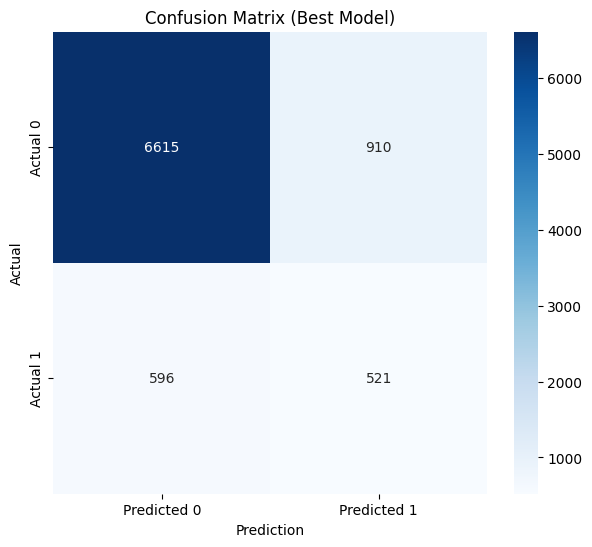

Confusion Matrix plot displayed.


<Figure size 800x700 with 0 Axes>

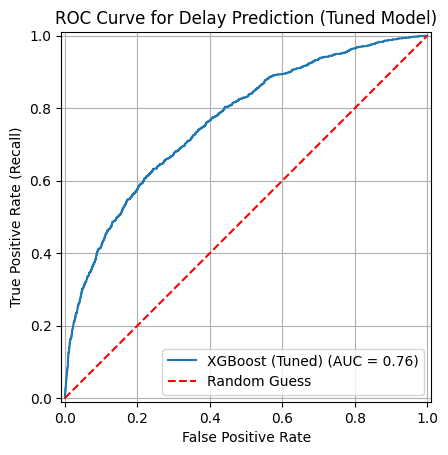

ROC AUC Curve plot displayed.

Test Set ROC AUC Score (Best Model): 0.7641

The full, optimized pipeline is ready for prediction.


In [9]:

# 2. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Delayed (0)', 'Delayed (1)']))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()
print("Confusion Matrix plot displayed.")

# 4. ROC AUC Curve
plt.figure(figsize=(8, 7))
RocCurveDisplay.from_predictions(y_test, y_pred_proba, name='XGBoost (Tuned)')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess') # Diagonal line
plt.title('ROC Curve for Delay Prediction (Tuned Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.legend()
plt.grid(True)
plt.show()
print("ROC AUC Curve plot displayed.")

roc_auc = auc(*roc_curve(y_test, y_pred_proba)[0:2])
print(f"\nTest Set ROC AUC Score (Best Model): {roc_auc:.4f}")

print("\nThe full, optimized pipeline is ready for prediction.")



--- STEP D: FEATURE IMPORTANCE ANALYSIS ---


C:\Users\karlt\AppData\Local\Temp\ipykernel_2468\384999329.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')


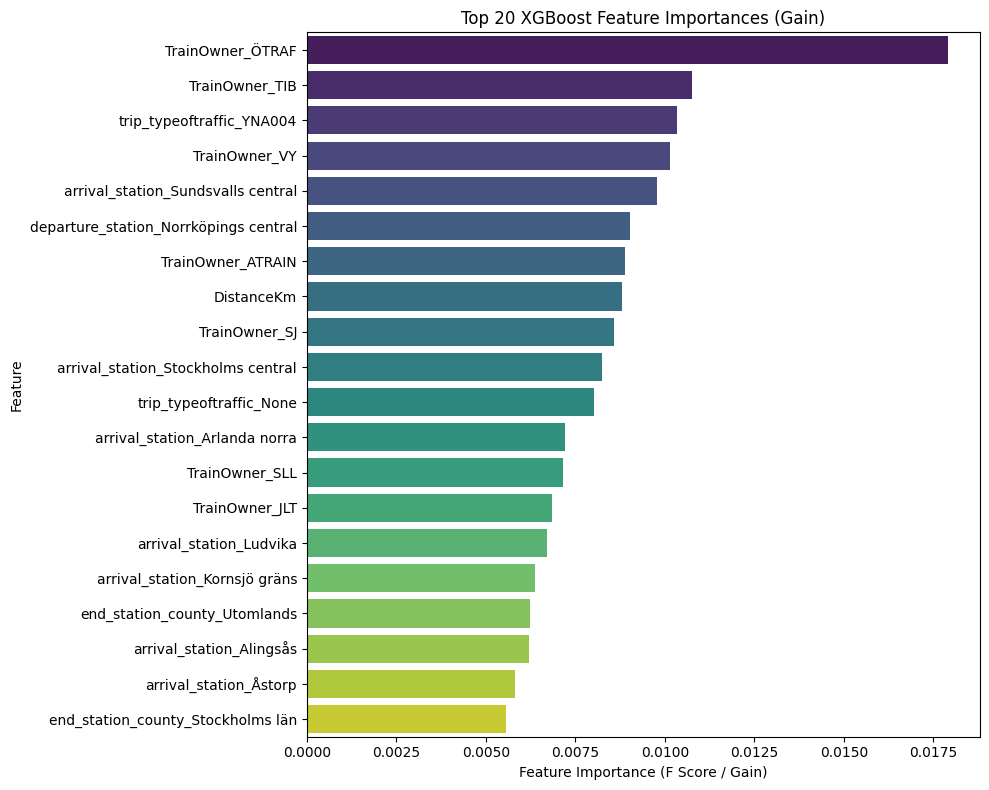

Top 20 Feature Importance plot displayed.


In [10]:
# --- Step D: Feature Importance Visualization ---
print("\n" + "="*50)
print("--- STEP D: FEATURE IMPORTANCE ANALYSIS ---")
print("="*50)

# 1. Get the trained classifier from the best pipeline
final_model = best_model.named_steps['classifier']

# 2. Extract feature names from the ColumnTransformer in the pipeline
# The get_feature_names_out() method provides the final feature names
# in the correct order: num, cat (OHE), bin (passthrough)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# 3. Create a DataFrame for importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': final_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# 4. Select top 20 features
top_n = 20
top_features = feature_importance_df.head(top_n).copy()

# 5. Clean up feature names for better visualization 
# (Removes prefixes like 'cat__', 'num__', 'bin__')
top_features['Feature'] = top_features['Feature'].str.replace(r'^(cat|num|bin)__', '', regex=True)

# 6. Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} XGBoost Feature Importances (Gain)')
plt.xlabel('Feature Importance (F Score / Gain)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
print(f"Top {top_n} Feature Importance plot displayed.")


In [ ]:
# Function to map the transformed name back to the original feature name
def map_to_original_feature(name, nominal_categorical_features):
    if name.startswith('num__') or name.startswith('bin__'):
        # Simple strip for numerical and binary features (e.g., 'num__DistanceKm' -> 'DistanceKm')
        return name.split('__', 1)[1]
    elif name.startswith('cat__'):
        # For categorical OHE features (e.g., 'cat__departure_station_Station_001')
        # 1. Strip 'cat__' prefix
        base_name = name.split('__', 1)[1] 
        # 2. Find the feature name among the known nominal categorical features
        for original_feature in nominal_categorical_features:
            if base_name.startswith(f"{original_feature}_"):
                return original_feature
        # Fallback for features that might not have a category value suffix, 
        # but are still in the OHE group (e.g., if onehot changes behavior)
        return base_name
    return name

C:\Users\karlt\AppData\Local\Temp\ipykernel_2468\2884820822.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\karlt\AppData\Local\Temp\ipykernel_2468\2884820822.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


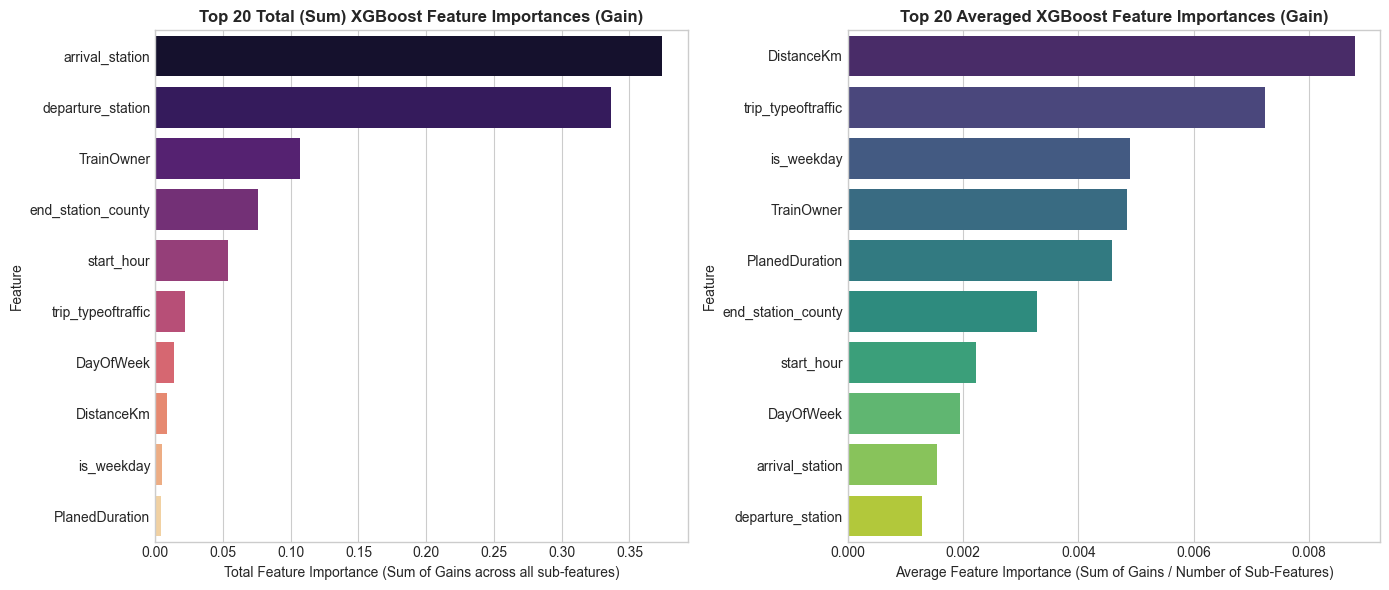

In [ ]:
#Create a detailed importance DataFrame mapping back to original features
detailed_importance_df = pd.DataFrame({
    'Feature_Detail': feature_names,
    'Importance': final_model.feature_importances_
})
detailed_importance_df['Original_Feature'] = detailed_importance_df['Feature_Detail'].apply(
        lambda x: map_to_original_feature(x, nominal_categorical_features)
    )

agg_result = detailed_importance_df.groupby('Original_Feature')['Importance'].agg(['sum', 'count']).reset_index()
agg_result = agg_result.rename(columns={'sum': 'Importance_Sum', 'count': 'Feature_Count'})
    
    # Calculate the average importance
agg_result['Average_Importance'] = agg_result['Importance_Sum'] / agg_result['Feature_Count']

feature_importance_agg = agg_result.rename(columns={'Original_Feature': 'Feature'})

# Select top 20 features by Average Importance
top_n = 20
top_features_sum = feature_importance_agg.sort_values(by='Importance_Sum', ascending=False).head(top_n).copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.style.use('seaborn-v0_8-whitegrid') # Optional: Adds a clean grid background

# --- Plot 1: Total (Sum) Feature Importance ---
# We pass the first axes object (axes[0]) to the 'ax' parameter.
sns.barplot(
    x='Importance_Sum',
    y='Feature',
    data=top_features_sum,
    palette='magma',
    ax=axes[0]
)

# Set title and labels using the axes object methods
axes[0].set_title(f'Top {top_n} Total (Sum) XGBoost Feature Importances (Gain)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Total Feature Importance (Sum of Gains across all sub-features)', fontsize=10)
axes[0].set_ylabel('Feature', fontsize=10)

# --- Plot 2: Averaged Feature Importance ---
# We pass the second axes object (axes[1]) to the 'ax' parameter.
sns.barplot(
    x='Average_Importance',
    y='Feature',
    data=top_features_avg,
    palette='viridis',
    ax=axes[1]
)

# Set title and labels using the axes object methods
axes[1].set_title(f'Top {top_n} Averaged XGBoost Feature Importances (Gain)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Average Feature Importance (Sum of Gains / Number of Sub-Features)', fontsize=10)
axes[1].set_ylabel('Feature', fontsize=10)

# --- Final Display ---
# Use tight_layout once on the figure to prevent titles/labels from overlapping
plt.tight_layout()

# Display the single figure containing both plots
plt.show()

In [43]:
# Save the best model pipeline to a file for future use
model_filename = "best_xgb_pipeline_final.joblib"
try:
    joblib.dump(best_model, model_filename)
    print(f"\nModel successfully saved to {model_filename}")
except Exception as e:
    print(f"\nWarning: Could not save model to file. Error: {e}")



Model successfully saved to best_xgb_pipeline_final.joblib


In [45]:
# Load the model back from the file to verify
model_filename = "best_xgb_pipeline_final.joblib"
try:
    loaded_model = joblib.load(model_filename)
    print(f"Model successfully loaded from {model_filename}.")
except FileNotFoundError:
    print(f"Could not load model. File '{model_filename}' not found. Make sure the file exists after training.")
except Exception as e:
    print(f"An error occurred during model loading: {e}")


Model successfully loaded from best_xgb_pipeline_final.joblib.


In [ ]:
# --- Step E: Future Predictions on Simulated Data ---
df_test = pd.read_parquet('planned_trips_final.parquet')
try:
    # 1. Load the model saved in Step B
    # NOTE: Using 'loaded_model' from Step E if available, otherwise loading again.
    if 'loaded_model' not in locals():
        loaded_model = joblib.load(model_filename)
        print(f"Model loaded from {model_filename}.")
    
    # 2. Loading the data
    df_future = df_test
    
    # 3. Clean and transform columns to match the model's required input
    df_to_predict = clean_and_rename_future_data(df_future.copy())
    
    # 4. Generate predictions (0: Not Delayed, 1: Delayed)
    future_predictions = loaded_model.predict(df_to_predict)
    
    # 5. Get prediction probabilities
    future_probas = loaded_model.predict_proba(df_to_predict)[:, 1]
    
    # 6. Store results
    df_future['Predicted_Delay'] = future_predictions
    df_future['Delay_Probability'] = future_probas

    print(f"\nPredictions generated for {len(df_future)} future trips.")
    print(f"Number of predicted delays (1): {df_future['Predicted_Delay'].sum()}")
    print("\nFirst 10 predictions:")
    print(df_future[['AdvertisedTrainIdent', 'duration_minutes', 'distance_km', 'Predicted_Delay', 'Delay_Probability']].head(10))
    
    # Example of how to filter and inspect high-risk trips
    high_risk_trips = df_future[df_future['Predicted_Delay'] == 1].sort_values(by='Delay_Probability', ascending=False)
    if not high_risk_trips.empty:
        print(f"\nTop 10 Highest-Risk Trips (Predicted Delayed):")
        print(high_risk_trips.head(10)[['AdvertisedTrainIdent', 'start_station', 'end_station', 'Delay_Probability']])
    else:
        print("\nNo delays were predicted in the simulated future data sample.")
        
except FileNotFoundError:
    print(f"\nPrediction failed: Model file '{model_filename}' not found. Run Step B first to save the model.")
except Exception as e:
    print(f"\nAn error occurred during future prediction: {e}")


Cleaning and renaming future data to match trained pipeline schema...
Future data schema matched successfully.

Predictions generated for 3631 future trips.
Number of predicted delays (1): 655

First 10 predictions:
  AdvertisedTrainIdent  duration_minutes  distance_km  Predicted_Delay  \
0                    1               0.0        0.000                0   
1                    1             332.0      350.195                1   
2                   10             461.0      527.675                1   
3                  100              59.0       90.413                0   
4                 1001              20.0       20.757                0   
5                 1004             174.0      176.079                1   
6                 1005              21.0       20.757                0   
7                 1007              19.0       20.757                0   
8                 1008             191.0      242.712                0   
9                 1009              21.0   